In [1]:
#!/usr/bin/env python

# --------------------------------------------------------
# Faster R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""

'\nDemo script showing detections in sample images.\n\nSee README.md for installation instructions before running.\n'

In [2]:
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
%matplotlib inline

In [3]:
CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('VGG16',
                  'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF',
                  'ZF_faster_rcnn_final.caffemodel')}

In [4]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [5]:
def demo(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

In [6]:
def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Faster R-CNN demo')
    parser.add_argument('--gpu', dest='gpu_id', help='GPU device id to use [0]',
                        default=0, type=int)
    parser.add_argument('--cpu', dest='cpu_mode',
                        help='Use CPU mode (overrides --gpu)',
                        action='store_true')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16]',
                        choices=NETS.keys(), default='vgg16')

    args = parser.parse_args()

    return args

In [ ]:
cfg.TEST.HAS_RPN = True  # Use RPN for proposals

demo_net = "vgg16"
cpu_mode = False
gpu_id = 0

prototxt = os.path.join(cfg.MODELS_DIR, NETS[demo_net][0],
                        'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS[demo_net][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

if cpu_mode:
    caffe.set_mode_cpu()
else:
    caffe.set_mode_gpu()
    caffe.set_device(gpu_id)
    cfg.GPU_ID = gpu_id
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print '\n\nLoaded network {:s}'.format(caffemodel)



Loaded network /home/ai2-c3p0/Documents/code/todd_working_directory/KaggleFisheries/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/000456.jpg
Detection took 0.099s for 300 object proposals


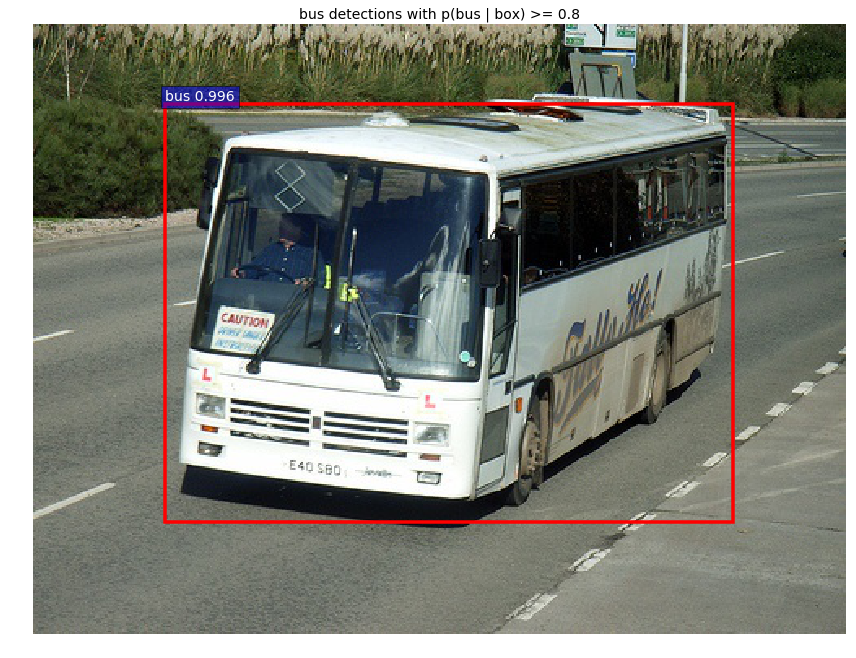

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/000542.jpg
Detection took 0.088s for 160 object proposals


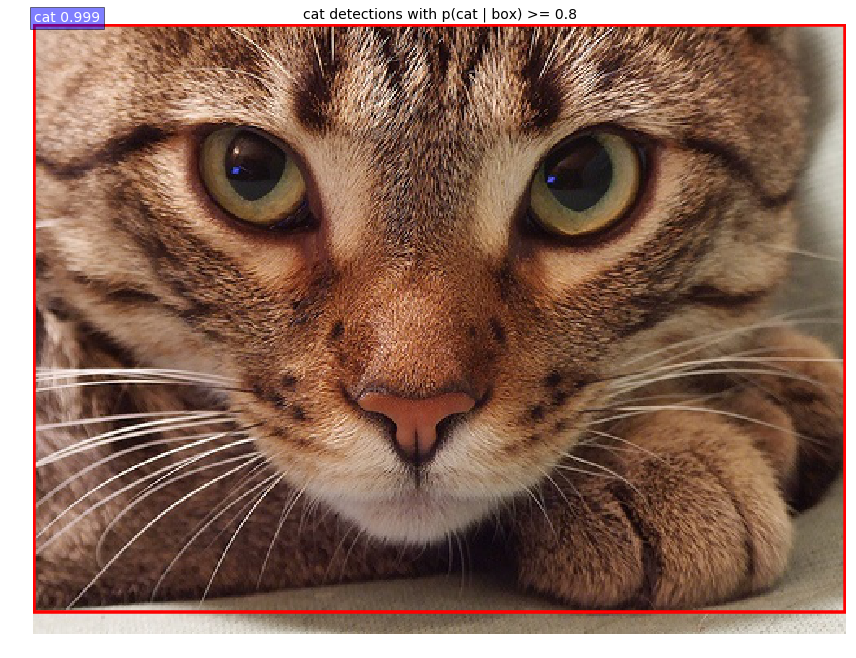

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/001150.jpg
Detection took 0.085s for 192 object proposals


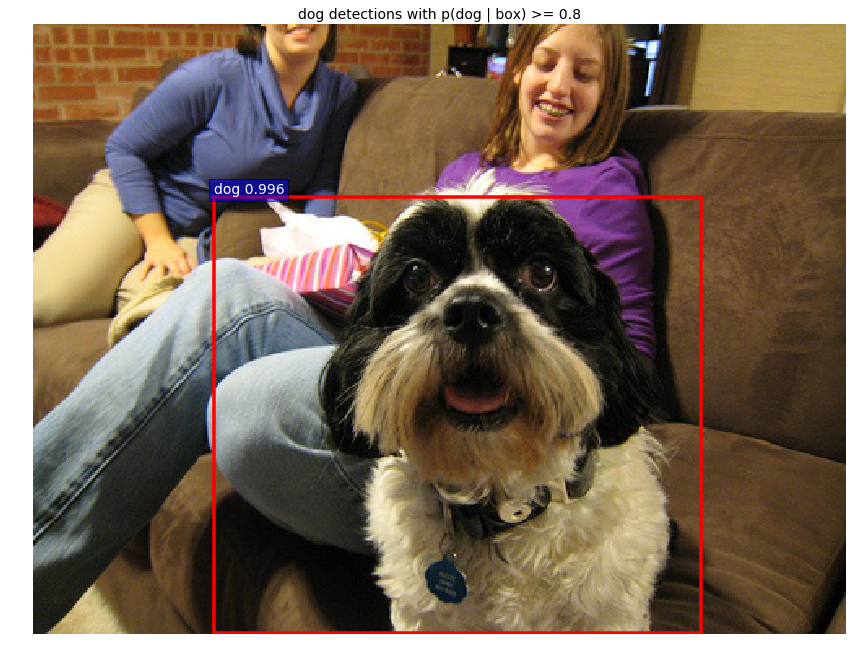

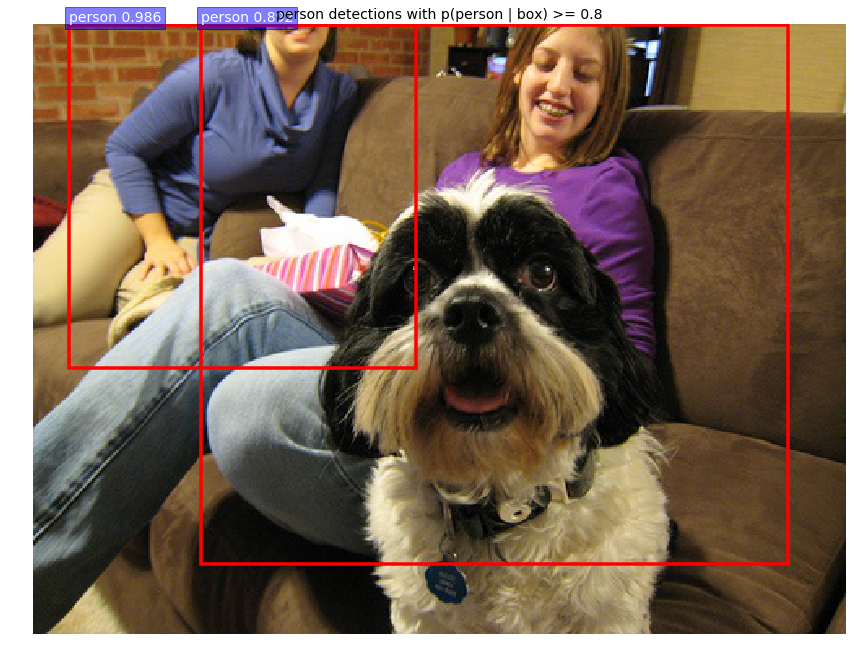

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/001763.jpg
Detection took 0.085s for 203 object proposals


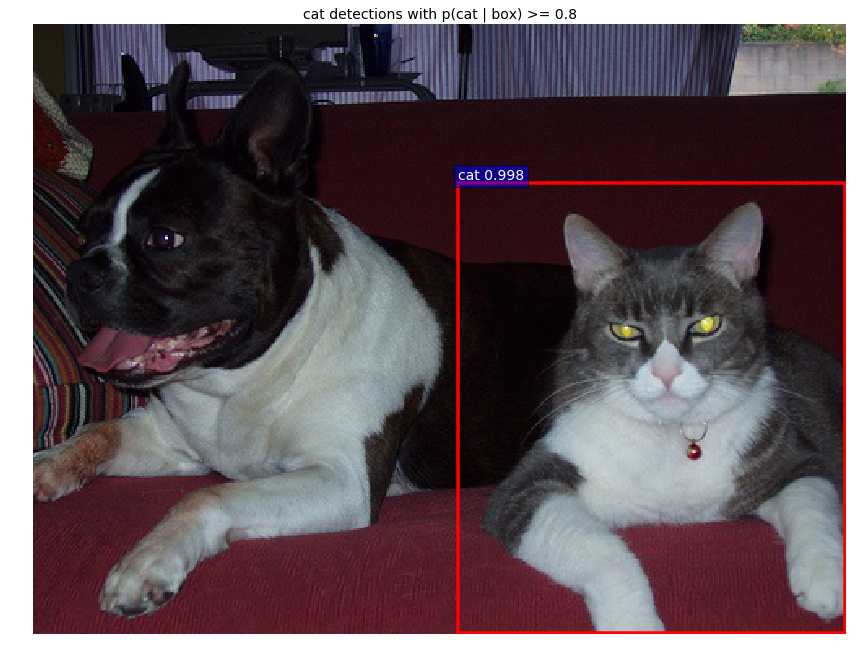

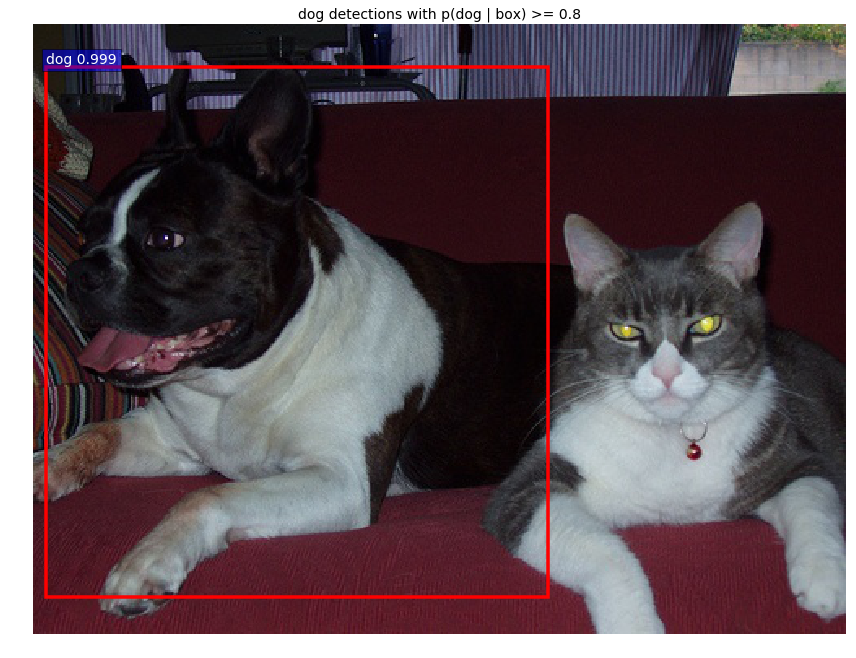

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/004545.jpg
Detection took 0.095s for 300 object proposals


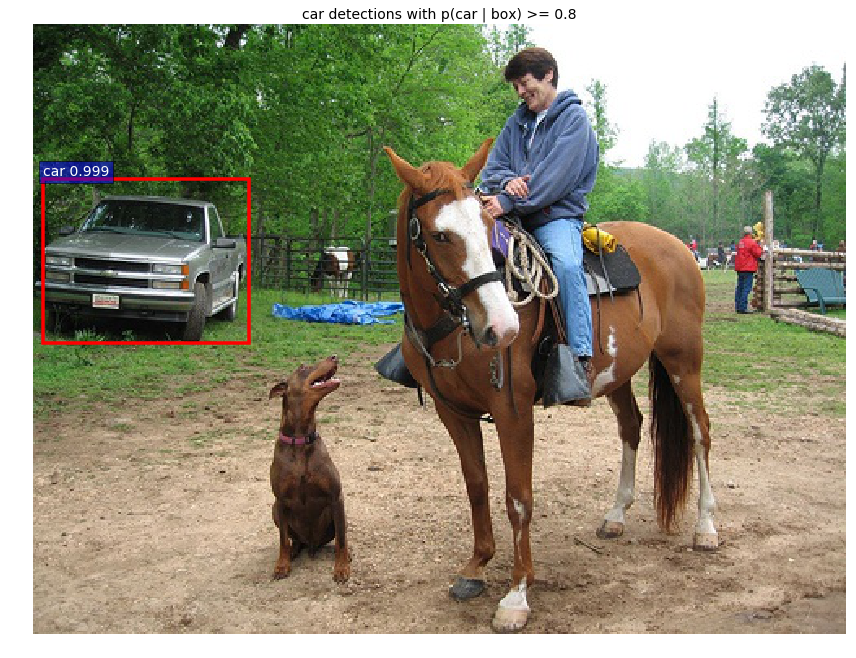

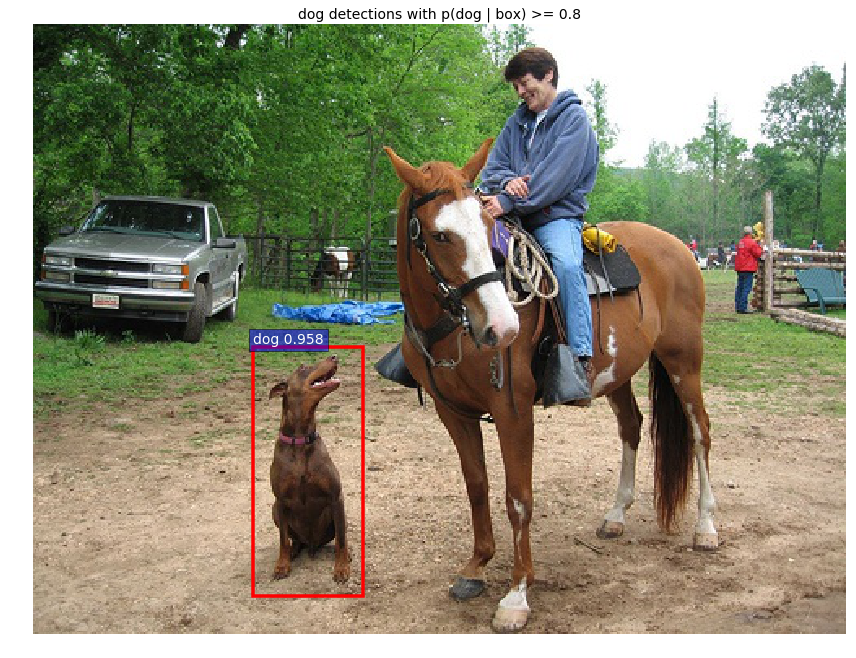

In [ ]:
# Warmup on a dummy image
im = 128 * np.ones((300, 500, 3), dtype=np.uint8)
for i in xrange(2):
    _, _= im_detect(net, im)

im_names = ['000456.jpg', '000542.jpg', '001150.jpg',
            '001763.jpg', '004545.jpg']
for im_name in im_names:
    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Demo for data/demo/{}'.format(im_name)
    demo(net, im_name)
    plt.show()